In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

Test data distribution:
Total test samples: 1409
Test set churn rate: 26.5%


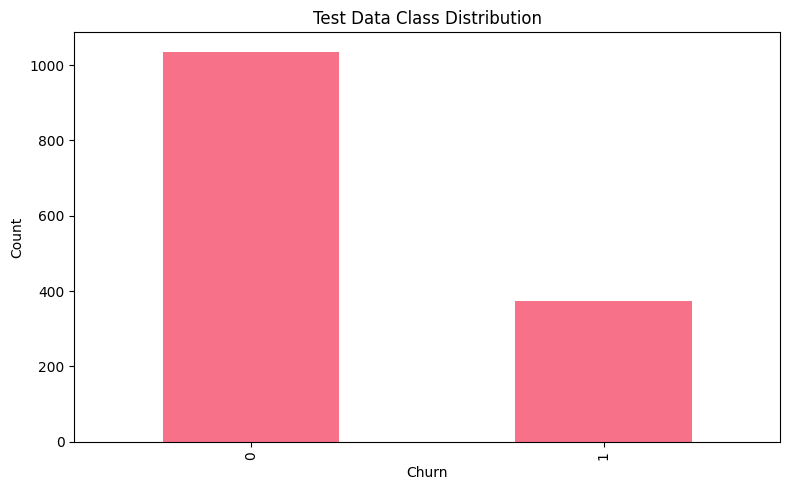

In [2]:
try:
    model = joblib.load('../JoblibModels/CatBoost_Tuned.pkl')

    # Load only test data for evaluation
    X_test = np.load('../new_artifacts/X_test_preprocessed.npz', allow_pickle=True)['arr_0']
    y_test = np.load('../new_artifacts/y_test_preprocessed.npz', allow_pickle=True)['arr_0']
    feature_names = np.load('../new_artifacts/feature_names.npy', allow_pickle=True)

    print("Test data distribution:")
    print(f"Total test samples: {len(y_test)}")
    print(f"Test set churn rate: {(y_test == 1).mean():.1%}")
    
    # Create DataFrame with test data only
    df = pd.DataFrame(X_test, columns=feature_names)
    df['Churn'] = y_test
    
    # Plot test data distribution
    plt.figure(figsize=(8, 5))
    pd.Series(y_test).value_counts().plot(kind='bar', title='Test Data Class Distribution')
    plt.xlabel('Churn')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise e

### Feature importance and distribution analysis



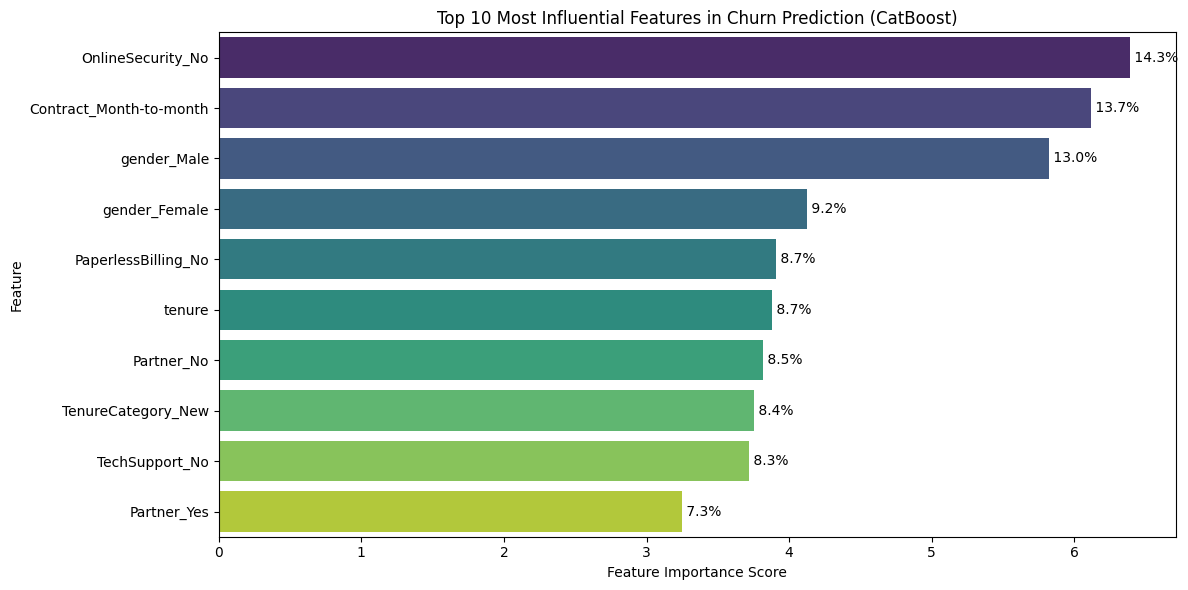

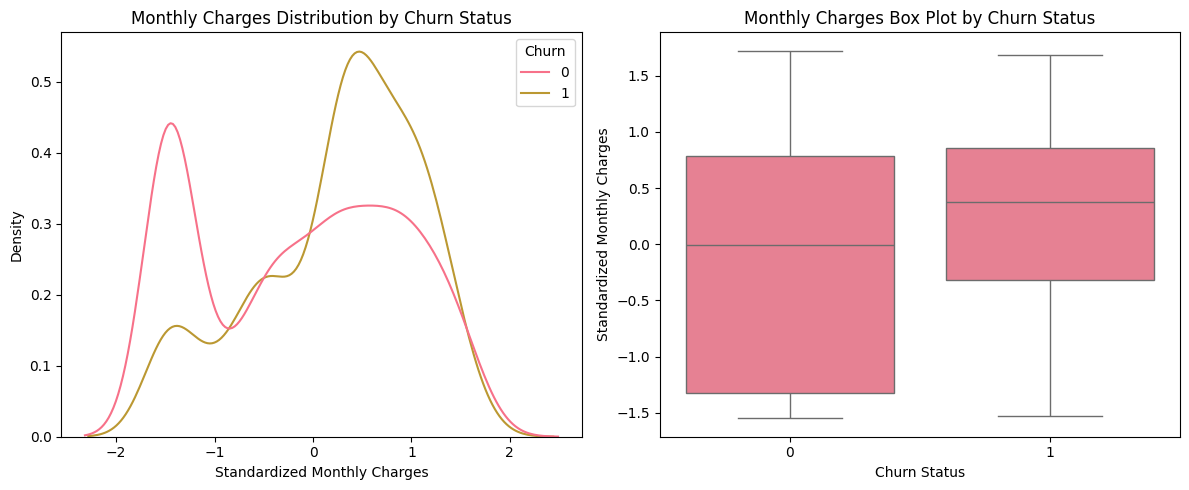

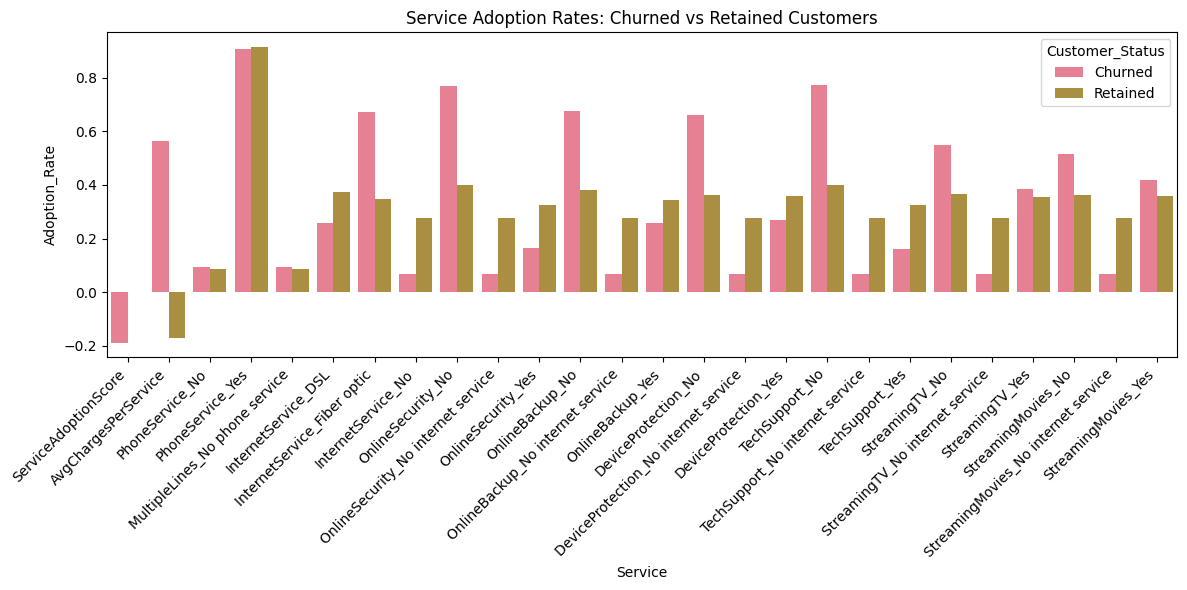

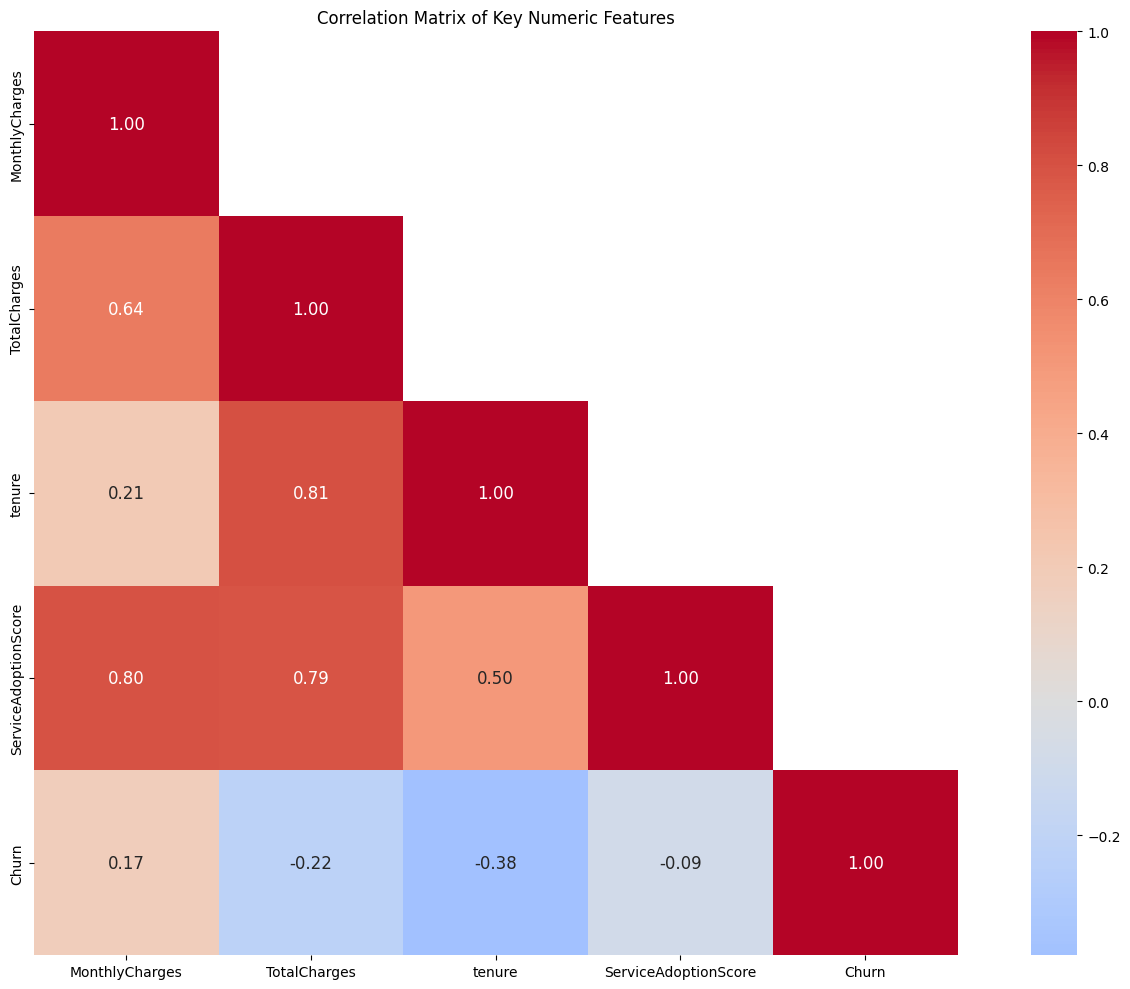

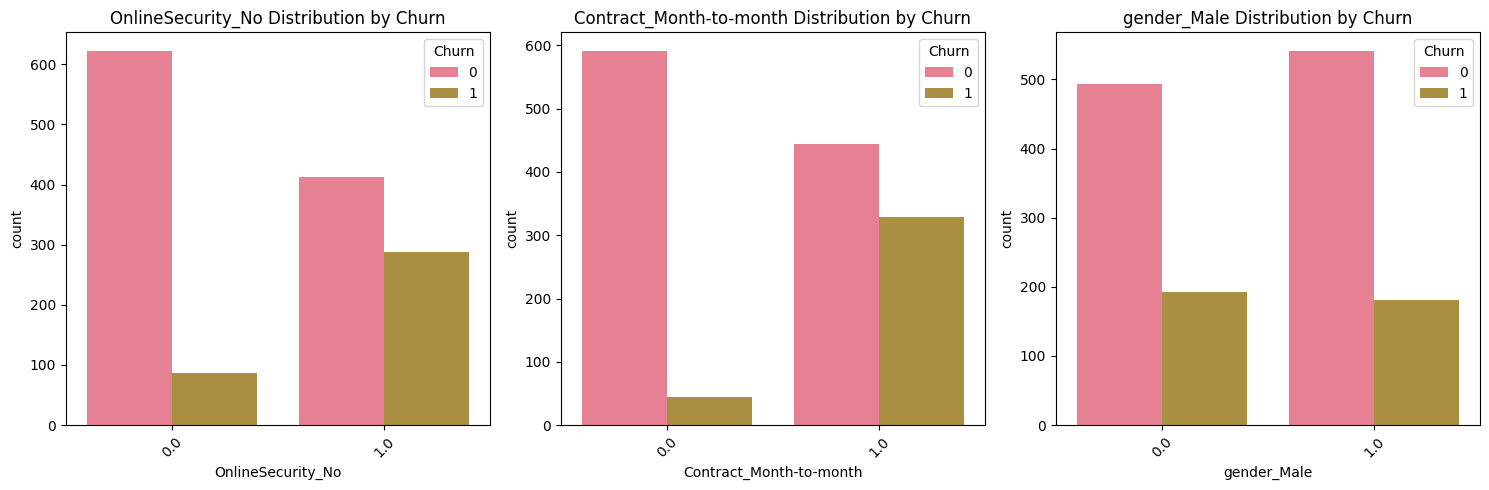

In [3]:
# Get feature importances from CatBoost model
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

# Create a more detailed feature importance visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=importance, x='importance', y='feature', palette='viridis')
plt.title('Top 10 Most Influential Features in Churn Prediction (CatBoost)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')


total_importance = importance['importance'].sum()
for i, v in enumerate(importance['importance']):
    percentage = (v / total_importance) * 100
    plt.text(v, i, f' {percentage:.1f}%', va='center')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
monthly_charges_idx = list(feature_names).index('MonthlyCharges')
monthly_charges = df.iloc[:, monthly_charges_idx]

plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x=monthly_charges, hue='Churn', common_norm=False)
plt.title('Monthly Charges Distribution by Churn Status')
plt.xlabel('Standardized Monthly Charges')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Churn', y=monthly_charges)
plt.title('Monthly Charges Box Plot by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Standardized Monthly Charges')
plt.tight_layout()
plt.show()


service_cols = [col for col in feature_names if any(service in col.lower() for service in ['service', 'security', 'backup', 'protection', 'support', 'streaming'])]
service_adoption = pd.DataFrame()

for col in service_cols:
    service_stats = df.groupby('Churn')[col].mean()
    service_adoption = pd.concat([service_adoption, pd.DataFrame({
        'Service': [col],
        'Churned': [service_stats[1]],
        'Retained': [service_stats[0]]
    })])


plt.figure(figsize=(12, 6))
service_adoption_melted = service_adoption.melt(id_vars=['Service'], var_name='Customer_Status', value_name='Adoption_Rate')
sns.barplot(data=service_adoption_melted, x='Service', y='Adoption_Rate', hue='Customer_Status')
plt.xticks(rotation=45, ha='right')
plt.title('Service Adoption Rates: Churned vs Retained Customers')
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 10))
relevant_numeric_features = ['MonthlyCharges', 'TotalCharges', 'tenure', 'ServiceAdoptionScore', 'Churn']
correlation_matrix = df[relevant_numeric_features].corr()
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            mask=mask,
            fmt='.2f',
            square=True,
            annot_kws={'size': 12})
plt.title('Correlation Matrix of Key Numeric Features')
plt.tight_layout()
plt.show()


top_5_features = importance.head().feature.tolist()
plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_5_features[:3]):  
    plt.subplot(1, 3, i+1)
    feature_idx = list(feature_names).index(feature)
    feature_values = df.iloc[:, feature_idx]
    
    if feature_values.nunique() <= 2:  
        sns.countplot(data=df, x=feature_values, hue='Churn')
        plt.title(f'{feature} Distribution by Churn')
    else:  # Continuous feature
        sns.boxplot(data=df, x='Churn', y=feature_values)
        plt.title(f'{feature} by Churn Status')
    
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Customer risk segmentations

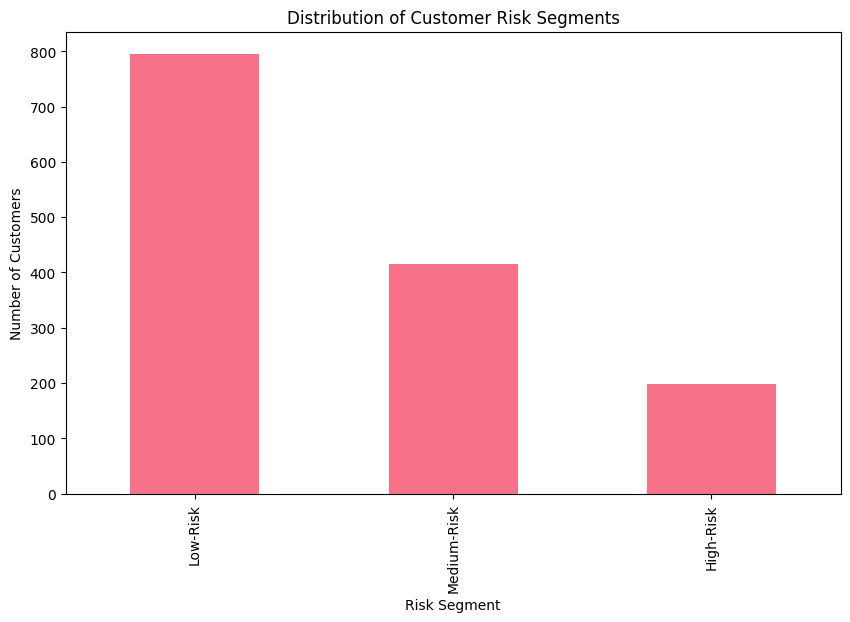


Segment Distribution:
risk_segment
Low-Risk       56.5%
Medium-Risk    29.5%
High-Risk      14.1%
Name: count, dtype: object


In [4]:
# Get probability predictions from CatBoost model
churn_prob = model.predict_proba(X_test)[:, 1]


df['churn_probability'] = churn_prob
df['risk_segment'] = pd.cut(df['churn_probability'], 
                           bins=[0, 0.3, 0.7, 1], 
                           labels=['Low-Risk', 'Medium-Risk', 'High-Risk'])

segment_dist = df['risk_segment'].value_counts()
plt.figure(figsize=(10, 6))
segment_dist.plot(kind='bar')
plt.title('Distribution of Customer Risk Segments')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.show()


print('\nSegment Distribution:')
print(segment_dist.apply(lambda x: f'{x/len(df)*100:.1f}%'))

### Detailed segment analysis

Segment Characteristics - Numerical Features:

              MonthlyCharges       TotalCharges       tenure      
                       mean   std         mean   std   mean   std
risk_segment                                                     
Low-Risk              -0.23  1.04         0.23  1.02   0.47  0.90
Medium-Risk            0.15  0.93        -0.23  0.84  -0.49  0.77
High-Risk              0.43  0.61        -0.74  0.41  -1.04  0.38

Segment Characteristics - Contract Types:

               Contract_Month-to-month  Contract_One year  Contract_Two year
risk_segment                                                               
Low-Risk                         0.24               0.34               0.42
Medium-Risk                      0.93               0.07               0.00
High-Risk                        1.00               0.00               0.00


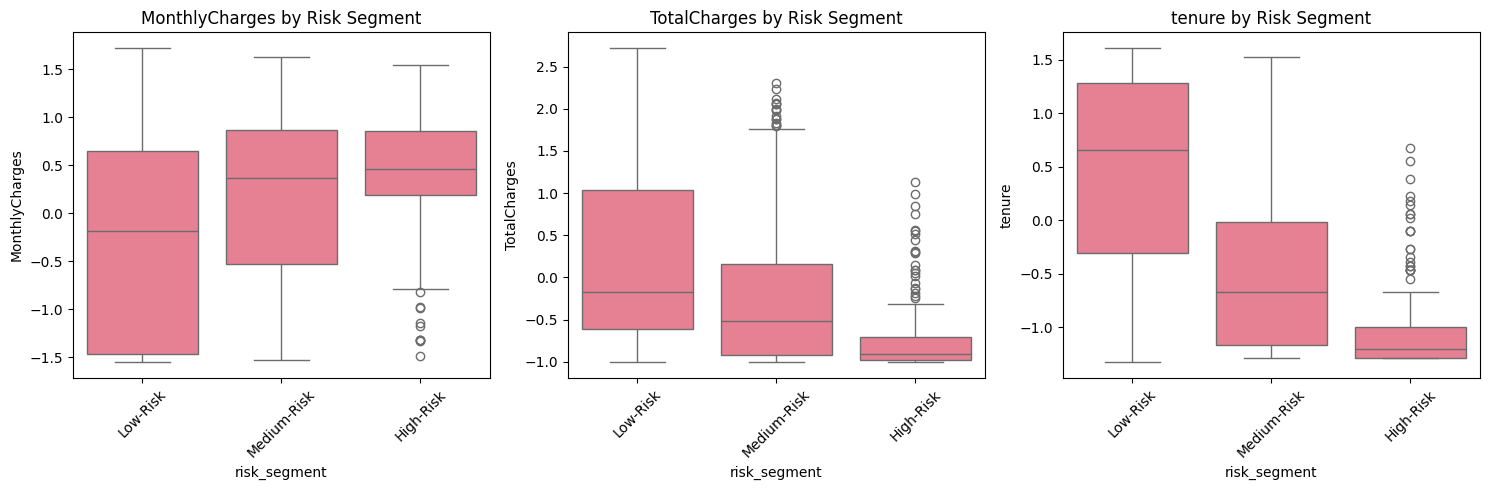

<Figure size 1000x600 with 0 Axes>

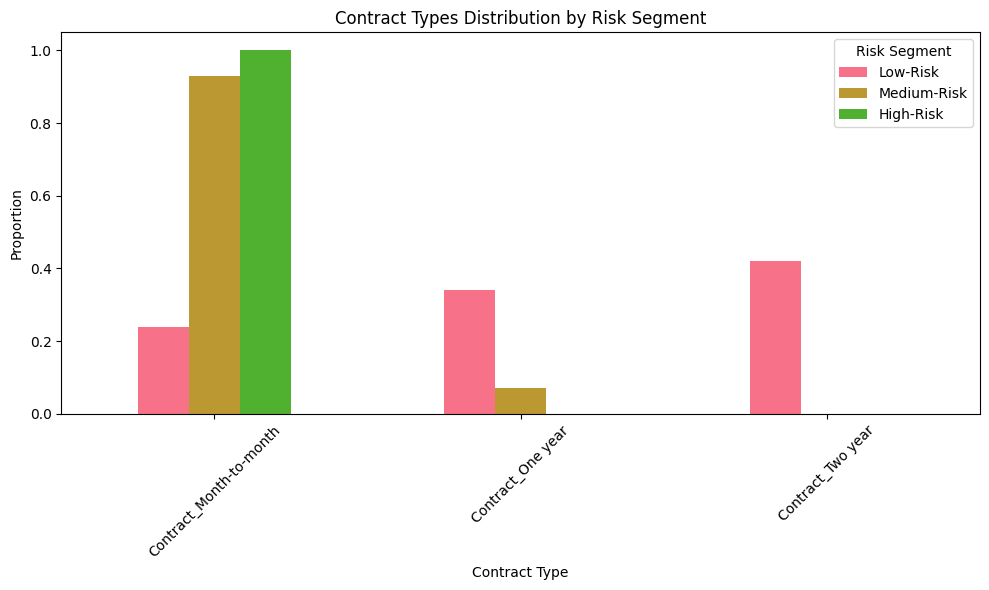

<Figure size 1200x600 with 0 Axes>

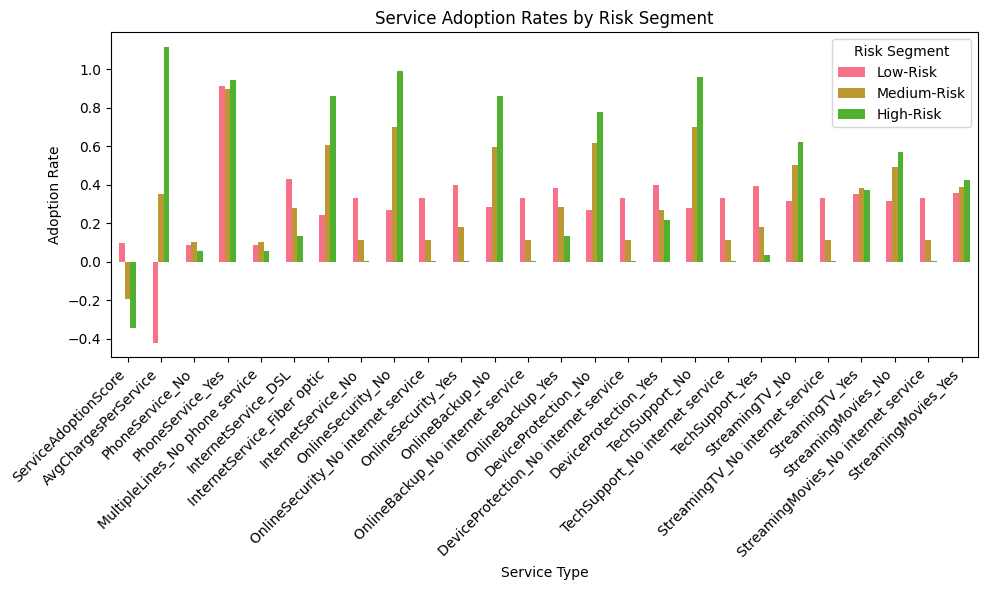

In [5]:

numerical_features = ['MonthlyCharges', 'TotalCharges', 'tenure']
numeric_analysis = df.groupby('risk_segment')[numerical_features].agg(['mean', 'std']).round(2)

# Analyze contract types (one-hot encoded columns)
contract_columns = [col for col in feature_names if 'Contract' in col]
contract_analysis = df.groupby('risk_segment')[contract_columns].mean().round(2)

print('Segment Characteristics - Numerical Features:')
print('\n', numeric_analysis)
print('\nSegment Characteristics - Contract Types:')
print('\n', contract_analysis)

# Visualize numerical features by segment
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='risk_segment', y=feature)
    plt.title(f'{feature} by Risk Segment')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize contract types by segment
contract_analysis_plot = contract_analysis.transpose()
plt.figure(figsize=(10, 6))
contract_analysis_plot.plot(kind='bar')
plt.title('Contract Types Distribution by Risk Segment')
plt.xlabel('Contract Type')
plt.ylabel('Proportion')
plt.legend(title='Risk Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Service adoption by segment
service_cols = [col for col in feature_names if any(service in col.lower() 
    for service in ['service', 'security', 'backup', 'protection', 'support', 'streaming'])]
service_adoption = df.groupby('risk_segment')[service_cols].mean()

plt.figure(figsize=(12, 6))
service_adoption.transpose().plot(kind='bar')
plt.title('Service Adoption Rates by Risk Segment')
plt.xlabel('Service Type')
plt.ylabel('Adoption Rate')
plt.legend(title='Risk Segment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Customer Lifetime Value (CLV) analysis

In [6]:
monthly_charges_idx = list(feature_names).index('MonthlyCharges')
tenure_idx = list(feature_names).index('tenure')

df['CLV'] = df.iloc[:, monthly_charges_idx] * df.iloc[:, tenure_idx]


segment_clv = df.groupby('risk_segment')['CLV'].agg(['mean', 'sum']).round(2)
print('Customer Lifetime Value by Segment:')
print(segment_clv)



high_risk_revenue = df[df['risk_segment'] == 'High-Risk'].iloc[:, monthly_charges_idx].sum()
print(f'\nMonthly Revenue at High Risk: ${high_risk_revenue:,.2f}')

Customer Lifetime Value by Segment:
              mean     sum
risk_segment              
Low-Risk      0.25  199.47
Medium-Risk   0.39  163.56
High-Risk    -0.34  -66.51

Monthly Revenue at High Risk: $84.52


### ROI analysis and resource allocation

ROI Analysis by Segment:
             Number of Customers  Total Cost  Expected Annual Revenue Saved  \
Segment                                                                       
High-Risk                    198       39600                       66930.49   
Medium-Risk                  415       41500                      244535.14   
Low-Risk                     796       39800                      599786.68   

               ROI %  
Segment               
High-Risk      69.02  
Medium-Risk   489.24  
Low-Risk     1407.00  


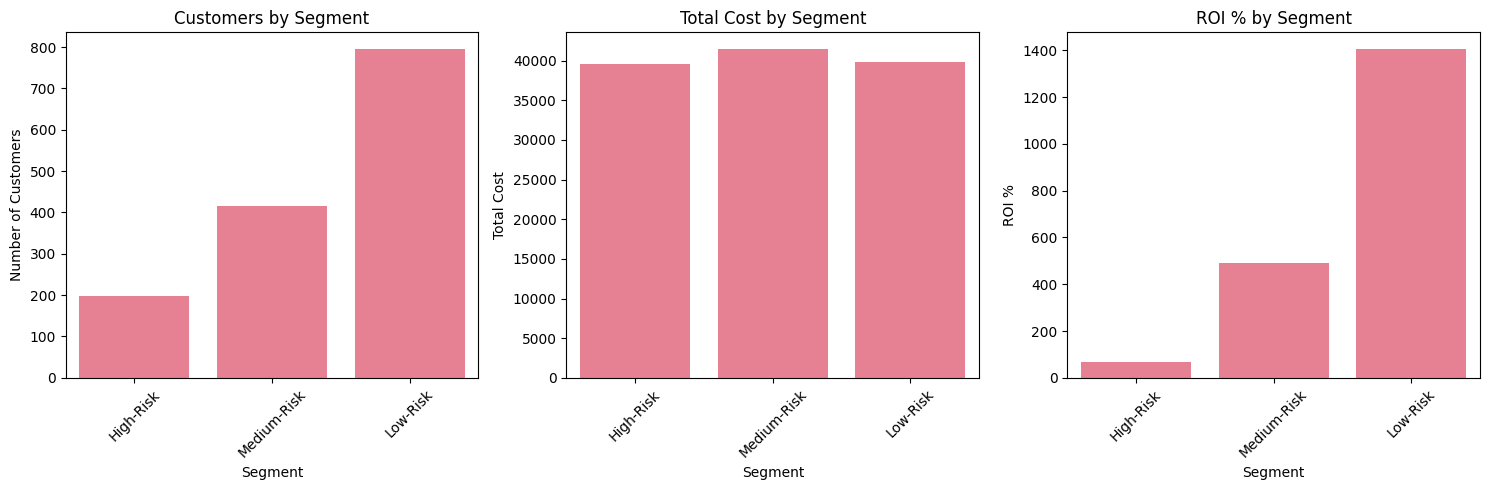

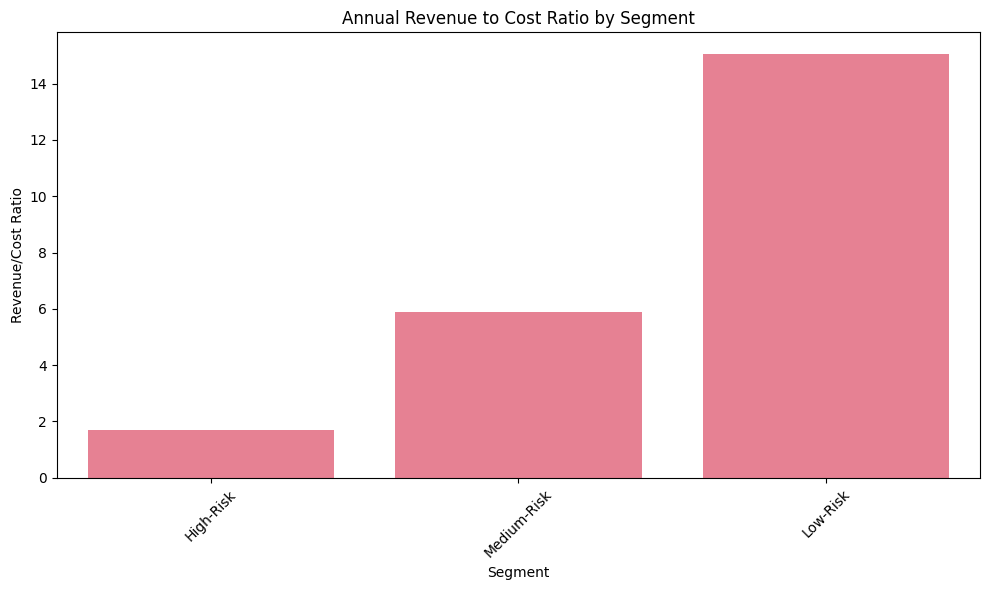

In [7]:
retention_cost_per_customer = {
    'High-Risk': 200,
    'Medium-Risk': 100, 
    'Low-Risk': 50   
}

# Expected retention rates
expected_retention_rate = {
    'High-Risk': 0.4,    
    'Medium-Risk': 0.7,
    'Low-Risk': 0.9    
}


monthly_charges_idx = list(feature_names).index('MonthlyCharges')

roi_analysis = pd.DataFrame()

charges_mean = df.iloc[:, monthly_charges_idx].mean()
charges_std = df.iloc[:, monthly_charges_idx].std()

for segment in ['High-Risk', 'Medium-Risk', 'Low-Risk']:
    segment_data = df[df['risk_segment'] == segment]
    

    customers = len(segment_data)
    total_cost = customers * retention_cost_per_customer[segment]
    
    # Unstandardize the monthly charges
    avg_monthly_revenue = (segment_data.iloc[:, monthly_charges_idx].mean() * charges_std) + 70  # Adding baseline average charge
    retained_customers = customers * expected_retention_rate[segment]
    annual_revenue_saved = retained_customers * avg_monthly_revenue * 12
    
    roi = (annual_revenue_saved - total_cost) / total_cost * 100
    
    roi_analysis = pd.concat([roi_analysis, pd.DataFrame({
        'Segment': [segment],
        'Number of Customers': [customers],
        'Total Cost': [total_cost],
        'Expected Annual Revenue Saved': [annual_revenue_saved],
        'ROI %': [roi]
    })])

roi_analysis = roi_analysis.set_index('Segment')
print('ROI Analysis by Segment:')
print(roi_analysis.round(2))


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=roi_analysis.index, y='Number of Customers', data=roi_analysis)
plt.title('Customers by Segment')
plt.xticks(rotation=45)


plt.subplot(1, 3, 2)
sns.barplot(x=roi_analysis.index, y='Total Cost', data=roi_analysis)
plt.title('Total Cost by Segment')
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
sns.barplot(x=roi_analysis.index, y='ROI %', data=roi_analysis)
plt.title('ROI % by Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
roi_analysis['Annual Revenue/Cost Ratio'] = roi_analysis['Expected Annual Revenue Saved'] / roi_analysis['Total Cost']
sns.barplot(x=roi_analysis.index, y='Annual Revenue/Cost Ratio', data=roi_analysis)
plt.title('Annual Revenue to Cost Ratio by Segment')
plt.ylabel('Revenue/Cost Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()